# Case study
Given a user’s past reviews on Yelp (available from yelp-challenge dataset),

When the user writes a review for a business she hasn't reviewed before,

How likely will it be a Five-Star review?

- Load data
- Visualize the data
- Featurize the data
- Join tables to populate the features
- Model the data: Logistic regression
- Evaluate the model
- Make prediction with the model

## Data source
[Yelp Dataset Round 10](yelp.com/dataset)

We took the full set of business, user, and review data in json format, pre-processed the data (converting from json to csv format) using this [script](https://github.com/Yelp/dataset-examples/blob/master/json_to_csv_converter.py).


# Step 1: Load the Data

We store aata in Pandas DataFrames.

We load three types of data from the dataset, each stored in a separate df.

`set_index()`: tells pandas to index the review df by the column named `review_id`. 

In [142]:
import pandas as pd

PATH = '/scratch/xun/docs/yelp_dataset_challenge_round10/'
biz_df = pd.read_csv(PATH + 'business.csv')
user_df = pd.read_csv(PATH + 'user.csv')
review_df = pd.read_csv(PATH + 'review.csv')

In [143]:
review_df = review_df.set_index('review_id')
user_df = user_df.set_index('user_id')
biz_df = biz_df.set_index('business_id')

## Useful Functions to Explore the DataFrames
`review_df.head()`: Print top rows in the data frame.

`review_df.describe()`: Generate various summary statistics, mean, max, count, etc.

# Step 2: Explore & Visualize the Data

## Example 1: Plot Review Star Rating Distribution

First ask yourself this question: 

Among all the reviews available in the dataset, what percentage of them are 5 star? 

One common mis-conception about Yelp, is that folks only come to Yelp to complaint about their negative experiences with a business, so most of the reviews "should" be low rating. 

However, this is a misconception, according to the below graph we plot, using the Yelp Open Dataset.

In [144]:
import seaborn as sns
%matplotlib inline

# Set context to "talk" for figure aesthetics 
sns.set_context(context="talk")
# set plot figure size to larger
sns.set(palette='Set2', rc={"figure.figsize": (15, 8)}, style="ticks")

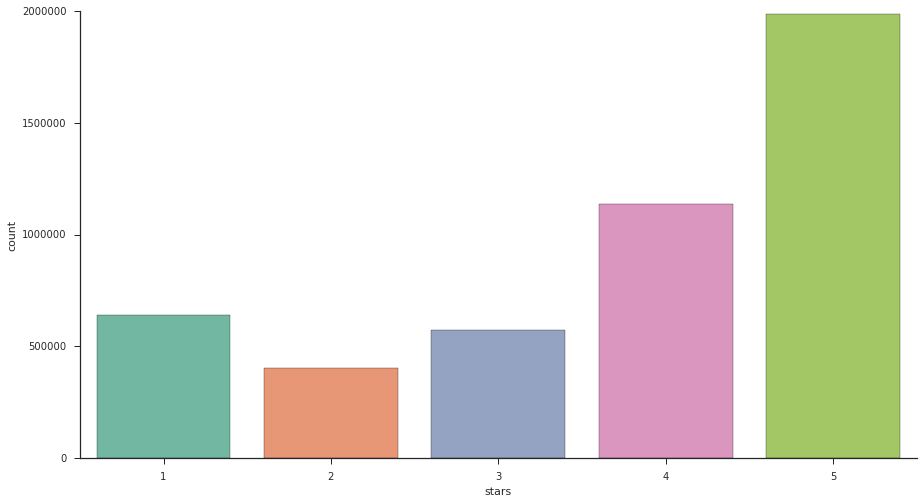

In [145]:
ax = sns.countplot(x='stars', data=review_df)
# Removing spines
sns.despine()

## Example 2: Plot Review Star Rating Distribution by year

From below graph,
- healthy growth over the years, on the amount of reviews people wrote every year. 
- later years, there seems to be a shift towards 5 star reviews. 

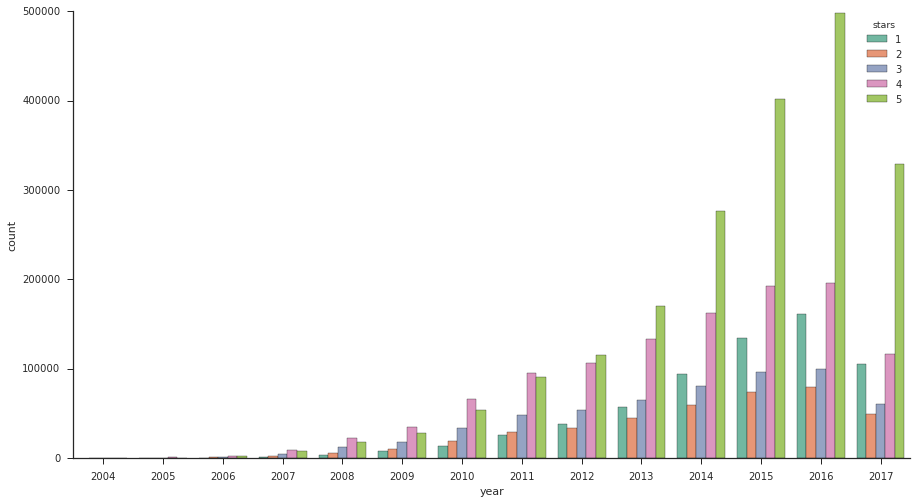

In [146]:
review_df['datetime'] = pd.to_datetime(review_df['date'])
review_df['year'] = review_df['datetime'].dt.year
ax = sns.countplot(x='year', data=review_df, hue='stars')
sns.despine()

# Step 3: Generate the Features

# 3.1 Examples Feature Extractions & Conversions

- Convert date string to date delta
  - For example, `business_age`
- Convert strings to categorical features
  - For example, `noise_level`: `{'quiet', 'loud', 'very loud'}`.
- Drop unused features
  - For example, `business_name`

In [147]:
def calculate_date_delta(df, from_column, to_column):
    datetime = pd.to_datetime(df[from_column])
    time_delta = datetime.max() - datetime
    df[to_column] = time_delta.apply(lambda x: x.days)
    df.drop(from_column, axis=1, inplace=True)

In [148]:
def to_length(df, from_column, to_column):
    df[to_column] = df[from_column].apply(lambda x: len(x))
    df.drop(from_column, axis=1, inplace=True)

In [149]:
def drop_columns(df, columns):
    for column in columns:
        df.drop(column, axis=1, inplace=True)

In [150]:
def to_boolean(df, columns):
    for column in columns:
        to_column = column+'_bool'
        df[to_column] = df[column].apply(lambda x: bool(x))
        df.drop(column, axis=1, inplace=True)

In [151]:
FILL_WITH = 0.0

In [152]:
def to_category(df, columns):
    for column in columns:
        df[column] = df[column].astype('category')
        # add FILL_WITH category for fillna() to work w/o error
        if (FILL_WITH not in df[column].cat.categories):
            df[column] = df[column].cat.add_categories([FILL_WITH])
        #print 'categories for ', column, ' include ', df[column].cat.categories

In [153]:
def category_rename_to_int(df, columns):
    for column in columns:
        df[column].cat.remove_unused_categories()
        size = len(df[column].cat.categories)
        #print 'column ', column, ' has ', size, ' columns, include ', df[column].cat.categories
        df[column] = df[column].cat.rename_categories(range(1, size+1))
        #print 'becomes ', df[column].cat.categories

In [154]:
calculate_date_delta(df=review_df, from_column='date', to_column='date_delta')

In [155]:
to_length(df=review_df, from_column='text', to_column='text_len')

In [156]:
drop_columns(df=review_df, columns=['year', 'datetime'])

In [157]:
review_df.fillna(value=0.0, inplace=True)

In [158]:
calculate_date_delta(df=user_df, from_column='yelping_since', to_column='date_delta')

In [159]:
to_length(df=user_df, from_column='friends', to_column='friends_count')

In [160]:
to_length(df=user_df, from_column='elite', to_column='elite_count')

In [161]:
drop_columns(df=user_df, columns=['name'])

In [162]:
user_df.fillna(value=0.0, inplace=True)

In [163]:
drop_columns(
    df=biz_df,
    columns=[
        'postal_code',
        'name',
        'city',
        'address',
        'state',
        'categories',
        'longitude',
        'latitude',
        'neighborhood',
        'hours.Monday',
        'hours.Tuesday',
        'hours.Wednesday',
        'hours.Thursday',
        'hours.Friday',
        'hours.Saturday',
        'hours.Sunday',
    ]
)

In [164]:
# print out all the unique values, help clean up data to be float type
#for column in biz_df.columns:
    #print column, biz_df[column].unique()

In [165]:
to_cat_columns = [
    'attributes.Ambience.casual',
    'attributes.AgesAllowed',
    'attributes.Alcohol',
    'attributes.NoiseLevel',
    'attributes.RestaurantsAttire',
    'attributes.RestaurantsPriceRange2',
    'attributes.BYOBCorkage',
    'attributes.WiFi',
    'attributes.Smoking',
]

to_category(
    df=biz_df,
    columns=to_cat_columns,
)

In [166]:
biz_df.fillna(value=FILL_WITH, inplace=True)

In [167]:
category_rename_to_int(
    df=biz_df,
    columns=to_cat_columns,
)

## 3.2 Join DataFrames to Populate the Features

After generatING the featureS within each dataframe, we join them together into one big dataframe.

Each join is a many-to-one join. 

After the joins, each row represents one review, including features from the review itself, the user who’s written the review, and the business the review is for.

In [168]:
# The `user_df` DataFrame is already indexed by the join key (`user_id`). Make sure it's on the right side of join.
review_join_user = review_df.join(user_df, on='user_id', lsuffix='_review', rsuffix='_user')

In [169]:
review_join_user_join_biz = review_join_user.join(biz_df, on='business_id', rsuffix='_biz')

In [170]:
drop_columns(df=review_join_user_join_biz, columns=['user_id', 'business_id'])

# Step 4: Train a Model

The process of training an ML model involves providing an ML algorithm (that is, the learning algorithm) with training data to learn from. The term ML model refers to the model artifact that is created by the training process.


## 4.1 Arrange Data into a Feature Matrix and a Target Array

**Feature matrix** X: 

All features gathered from business, user, and review dataframes.

Two-dimensional array of features with shape = (n_samples, n_features)

**Target array** y: 

What we'd like to predict: Whether the review is Five-star or not.

Array of labels with shape = (n_samples)

In [171]:
# Target y is whether a review is five-star (True / False)
y = review_join_user_join_biz.stars.apply(lambda x: x == 5)

# Exclude the `stars` columns from the feature matrix, since it is the target
X = review_join_user_join_biz
review_join_user_join_biz.drop('stars', axis=1, inplace=True)

# get the feature names - this will be useful for the model visualization and feature analysis
features = X.columns.values

## 4.2 Split Training and Testing Set

- Training set: used for an machine learning algorithm to train from. 
- Testing set: used to to estimate / evaluate how well the model has been trained.

In [172]:
from sklearn.cross_validation import train_test_split

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [173]:
print 'training data shape', X_train.shape
print 'test data shape', X_test.shape
print 'converted label data shape', y_train.shape
print 'features', features

training data shape (3552672, 109)
test data shape (1184225, 109)
converted label data shape (3552672,)
features ['funny_review' 'useful_review' 'cool_review' 'date_delta_review'
 'text_len' 'useful_user' 'compliment_photos' 'compliment_list'
 'compliment_funny' 'compliment_plain' 'review_count' 'fans'
 'compliment_note' 'funny_user' 'compliment_writer' 'compliment_cute'
 'average_stars' 'compliment_more' 'compliment_hot' 'cool_user'
 'compliment_profile' 'compliment_cool' 'date_delta_user' 'friends_count'
 'elite_count' 'attributes.Ambience.divey' 'attributes.RestaurantsDelivery'
 'attributes.DogsAllowed' 'attributes.HairSpecializesIn.coloring'
 'attributes.BestNights.sunday' 'attributes.BYOB' 'attributes.AgesAllowed'
 'attributes.Music.video' 'attributes.Alcohol' 'attributes.Ambience.classy'
 'attributes.RestaurantsTableService' 'attributes.Ambience.touristy'
 'attributes.RestaurantsCounterService' 'attributes.Corkage'
 'attributes.RestaurantsGoodForGroups' 'attributes.BusinessAccept

## 4.3 What Model to Use? Some Examples

- Decision Tree: predicts the value of a target variable by learning simple decision rules inferred from the data features
- Random Forest: combines de-correlated trees, where each tree is built from a bootstrap sample and node splits are calculated from random feature subsets
- Ensemble Model: combine predictions of several models in order to improve the accuracy (decrease bias) and robustness (decrease variance) over a single model

The model we used here: **Logistic Regression**

Logistic regression estimates the probability of a binary response based on one or more features.

The probabilities describing the possible outcomes of a single trial are modeled using a logistic function.

Here we estimate the probability of a review being five-star.

## 4.4 Normalize the Features

Standardize features by removing the mean and scaling to unit variance.
- Logistic Regression requires all features normalized.

In [174]:
from sklearn import preprocessing

scaler = preprocessing.StandardScaler().fit(X_train)

X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

## 4.5 Cross Validation

Holding out a portion of the training data for model evaluation, and do this for `n_folds`.
- Ensure that the model does not overfit the training data.
- Select optimal model parameters.

In [175]:
from sklearn.cross_validation import cross_val_score
import numpy as np

# Function used to print cross-validation scores
def training_score(est, X, y, cv):
    acc = cross_val_score(est, X, y, cv = cv, scoring='accuracy')
    roc = cross_val_score(est, X, y, cv = cv, scoring='roc_auc')
    print '5-fold Train CV | Accuracy:', round(np.mean(acc), 3),'+/-', \
    round(np.std(acc), 3),'| ROC AUC:', round(np.mean(roc), 3), '+/-', round(np.std(roc), 3)

In [176]:
from sklearn import linear_model

# Build model using default parameter values
lrc = linear_model.LogisticRegression()

In [177]:
from sklearn.cross_validation import StratifiedKFold

# cross-validation 
cv = StratifiedKFold(y_train, n_folds=5, shuffle=True)

# Step 5: Evaluation the Model

## 5.1 Metrics

- Accuracy: percentage of labels correctly predicted. The higher the better.
- ROC AUC: ROC curve, is a graphical plot that illustrates the diagnostic ability of a binary classifier system as its discrimination threshold is varied. "AUC" ("Area Under Curve”). The higher the better.

In [178]:
# print cross-validation scores
training_score(est=lrc, X=X_train_scaled, y=y_train, cv=cv)

5-fold Train CV | Accuracy: 0.76 +/- 0.001 | ROC AUC: 0.836 +/- 0.001


## 5.2 Evaluation via Confusion Matrix 

In [179]:
# Compute confusion matrix
import matplotlib.pyplot as plt
from sklearn.cross_validation import train_test_split
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Run classifier
lrc_fit = lrc.fit(X_train_scaled, y_train)
y_pred = lrc_fit.predict(X_test_scaled)
cm = confusion_matrix(y_test, y_pred)

Normalized confusion matrix
[[ 0.82538263  0.17461737]
 [ 0.33058539  0.66941461]]


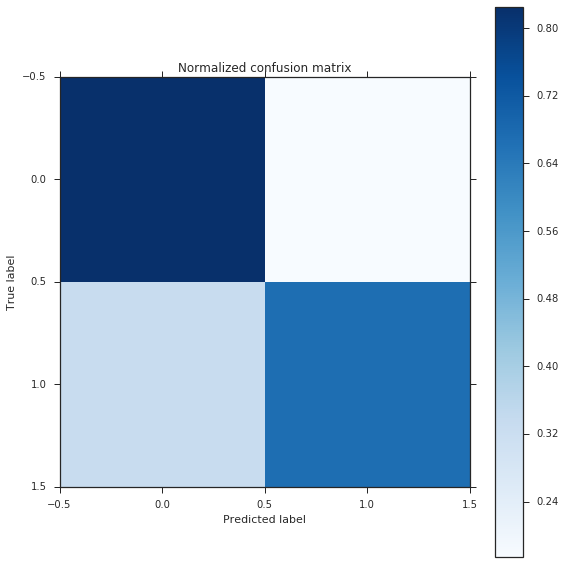

In [180]:
# Normalize the confusion matrix by row (i.e by the number of samples in each class)
cm_normalized = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
print('Normalized confusion matrix')
print(cm_normalized)
plt.figure(figsize=(8, 8))
plot_confusion_matrix(cm_normalized, title='Normalized confusion matrix')
plt.show()

## 5.3 Make Prediction with the Model

Process: 
- Randomly pick a few anonymous users from the dataset.
- Randomly pick a few businesses from the dataset.
- Predict whether the user will give the business a review with five-star rating.

In [198]:
def predict_given_user_biz(user, biz, review_df):
    a_user = user.copy()
    a_biz = biz.copy()
    # The review hasn't actually be written yet.
    # XXX(xun): We fake the feature using global mean/avg values to create a "general" review. 
    #   There are many other/better ways to fake the review to be more representative
    #   (e.g. draw from the real distribution, or avg of the user / the biz). 
    a_review = pd.DataFrame(
        {
            'funny': review_df['funny'].mean(),
            'user_id': a_user.index,
            'business_id': a_biz.index,
            'useful': review_df['useful'].mean(),
            'cool': review_df['cool'].mean(),
            'date_delta': 0.0, # the review is written the most recently
            'text_len': review_df['text_len'].mean(),
        }
    )

    a_review_join_user = a_review.join(a_user, on='user_id', lsuffix='_review', rsuffix='_user')
    a_X_test = a_review_join_user.join(a_biz, on='business_id', rsuffix='_biz')

    drop_columns(df=a_X_test, columns=['user_id', 'business_id'])
    a_X_test.fillna(value=FILL_WITH, inplace=True)
    
    a_X_test_scaled = scaler.transform(a_X_test)
    
    a_y_pred = lrc_fit.predict(a_X_test_scaled)
    a_y_pred_proba = lrc_fit.predict_proba(a_X_test_scaled)
    
    print a_y_pred[0], ', with probability [False, True] == ', a_y_pred_proba[0]

In [182]:
user1 = user_df[user_df.index == 'kEtR1ZVL3Xr-tEX7lg16dQ']
#print user1.review_count
print user1.average_stars

user_id
kEtR1ZVL3Xr-tEX7lg16dQ    4.96
Name: average_stars, dtype: float64


In [183]:
user2 = user_df[user_df.index == 'Hj20fg3vyzKnJwnLn_rMqw']
#print user2.review_count
print user2.average_stars

user_id
Hj20fg3vyzKnJwnLn_rMqw    4.55
Name: average_stars, dtype: float64


In [184]:
user3 = user_df[user_df.index == 'om5ZiponkpRqUNa3pVPiRg']
#print user2.review_count
print user3.average_stars

user_id
om5ZiponkpRqUNa3pVPiRg    3.94
Name: average_stars, dtype: float64


In [185]:
biz1 = biz_df[biz_df.index == 'u-SJ5QUwrNquL9VnXwl8cg']
#print biz1.review_count
print biz1.stars

business_id
u-SJ5QUwrNquL9VnXwl8cg    4.5
Name: stars, dtype: float64


In [186]:
biz2 = biz_df[biz_df.index == 'MtUUc5w3HuDMcmL89RcG6Q']
#print biz2.review_count
print biz2.stars

business_id
MtUUc5w3HuDMcmL89RcG6Q    2.5
Name: stars, dtype: float64


## biz1: https://www.yelp.com/biz/postino-arcadia-phoenix

<img src="postino-arcadia-phoenix.png" alt="postino-arcadia-phoenix" width="800">

## biz2 https://www.yelp.com/biz/port-authority-of-allegheny-county-pittsburgh

<img src="port-authority-of-allegheny-county-pittsburgh.png" alt="port-authority-of-allegheny-county-pittsburgh" width="800">

### Make predictions for user[1,2,3]'s review on biz1

In [199]:
predict_given_user_biz(user=user1, biz=biz1, review_df=review_df)
predict_given_user_biz(user=user2, biz=biz1, review_df=review_df)
predict_given_user_biz(user=user3, biz=biz1, review_df=review_df)

True , with probability [False, True] ==  [ 0.0871309  0.9128691]
True , with probability [False, True] ==  [ 0.21115779  0.78884221]
False , with probability [False, True] ==  [ 0.8328338  0.1671662]


### Make predictions for user[1,2,3]'s review on biz2

In [200]:
predict_given_user_biz(user=user1, biz=biz2, review_df=review_df)
predict_given_user_biz(user=user2, biz=biz2, review_df=review_df)
predict_given_user_biz(user=user3, biz=biz2, review_df=review_df)

True , with probability [False, True] ==  [ 0.35877821  0.64122179]
False , with probability [False, True] ==  [ 0.61076983  0.38923017]
False , with probability [False, True] ==  [ 0.9668934  0.0331066]


# Step 6 & Beyond: Loop Through the Process

First trial usually won’t be the best. We usually loop through the above steps multiple times, each time we look at the features, find out feature correlations, add / remove / adjust feature representation, change the model to use, or do parameter tuning for the model, etc. 

# Try out Yelp Dataset Challenge Round 10

yelp.com/dataset/challenge 
August 30, 2017 - December 31st, 2017

[Yelp Blogpost](https://engineeringblog.yelp.com/2017/08/yelp-open-dataset-and-dataset-challenge-round-10.html)

We challenge students and professionals to use our data in innovative ways and break ground in research. 
